## EXAMPLE Quadtree

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

C:\Users\leijnse\AppData\Local\Temp\ipykernel_2063516\186700442.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
# Initialize SfincsModel Python class with the artifact data catalog which contains publically available data for North Italy
# we overwrite (mode='w+') the existing model in the root directory if it exists
sf = SfincsModel(data_libs=["artifact_data"], root="test_quadtree", mode="w+")

In [4]:
# Specify an input dictionary with the grid settings x0,y0,dx,dy,nmax,mmax,rotation and epsg code.
# create SFINCS model with regular grid and characteristics of the input dictionary:
sf.setup_grid(
    x0=318650,
    y0=5040000,
    dx=50.0,
    dy=50.0,
    nmax=107,
    mmax=250,
    rotation=27,
    epsg=32633,
)

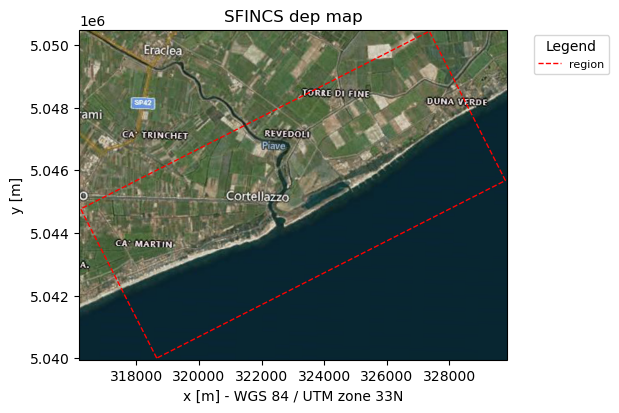

In [5]:
# show the model grid outline
# sf.region.boundary.plot(figsize=(6,6))
_ = sf.plot_basemap(plot_region=True, bmap="sat", zoomlevel=12)

In [6]:
# now create a geodataframe that covers a part of the model grid
datasets_dep = [{"elevtn": "merit_hydro", "zmin": 0.001}, {"elevtn": "gebco"}]

# Add depth information to modelgrid based on these chosen datasets
sf.setup_dep(datasets_dep=datasets_dep)
sf.setup_mask_active(zmin=-5, reset_mask=True)
sf.setup_mask_bounds(btype="waterlevel", zmax=-5, reset_bounds=True)


In [7]:
# derive river from hydrography data based on a minimum river length (river_len) 
# and minimum upstream area (river_upa)

sf.setup_river_inflow(
    hydrography='merit_hydro',
    river_len=1000,
    river_upa=50, 
    keep_rivers_geom=True
)


<GeoAxesSubplot:title={'center':'SFINCS dep map'}, xlabel='x [m] - WGS 84 / UTM zone 33N', ylabel='y [m]'>

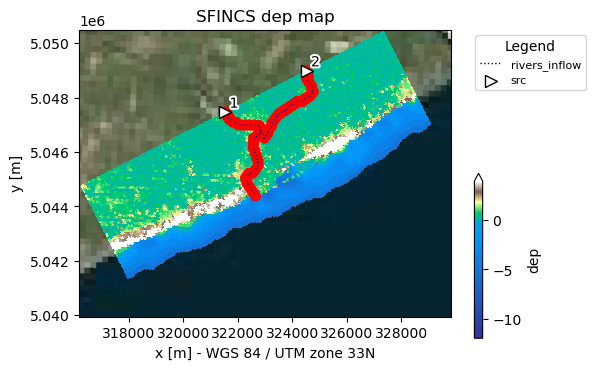

In [8]:
gdf_riv = sf.geoms['rivers_inflow'].copy()
gdf_riv_buf = gdf_riv.assign(geometry=gdf_riv.buffer(200))
gdf_riv_buf["refinement_level"] = 2

# Make a plot of model
# note the src points and derived river network
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat")

# plot gdf_riv on top
gdf_riv_buf.plot(ax=ax, color="red", linewidth=0.5)

In [9]:
import importlib

from hydromt_sfincs import quadtree

# NOTE this is to not have to restart the kernel all the time
importlib.reload(quadtree)

# create a quadtree object
qt = quadtree.QuadtreeGrid()

In [10]:
qt.build(x0=318650, y0=5040000, dx=50.0, dy=50.0, nmax=107, mmax=250, rotation=27, epsg=32633,
         refinement_polygons=gdf_riv_buf)

Building mesh ...
Finding points in polygons ...
Level 3 ...
Level 2 ...
Level 1 ...
Refining cells ...
Level 3 ...
Level 2 ...
Level 1 ...
Counting number of cells ...
Setting cell indices ...
Making XUGrid ...
Found nodes in 0.0475 seconds
Get rid of duplicates 0.1133 seconds
Number of cells : 48905
Time elapsed : 2.331709861755371 s
Finding neighbors ...
Time elapsed : 0.7630424499511719 s


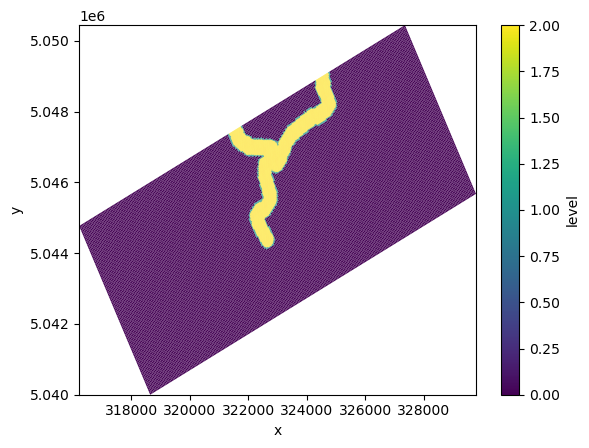

In [11]:
qt.data["level"].ugrid.plot()

## Uncomment for read/write

In [12]:
# qt.write("sfincs2.nc")

# qt2 = quadtree.QuadtreeGrid()
# qt2.read("sfincs2.nc")

In [13]:
da = sf.data_catalog.get_rasterdataset("gebco", 
                        bbox=sf.mask.raster.transform_bounds(4326),
                        buffer=10,
                        variables=["elevtn"],
                        zoom_level=(sf.grid.raster.res, "meter"),)

qt.set_bathymetry(da_dep=da)

AttributeError: module 'hydromt.workflows' has no attribute 'mesh'

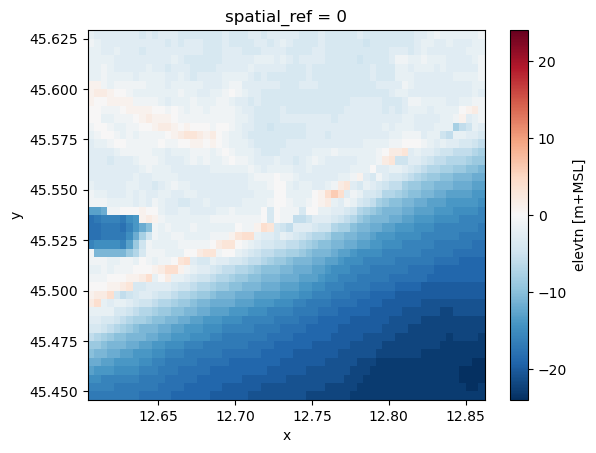

In [14]:
da.plot()

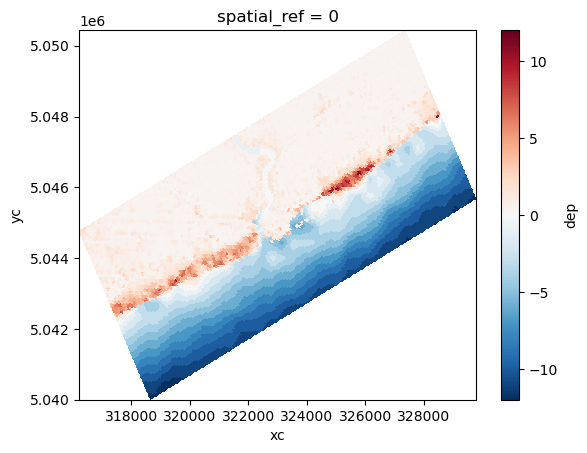

In [15]:
sf.grid["dep"].plot(x="xc", y="yc")

In [ ]:
qt.data["z"].ugrid.plot()

KeyError: 'z'

Build new mask for:sfincs...


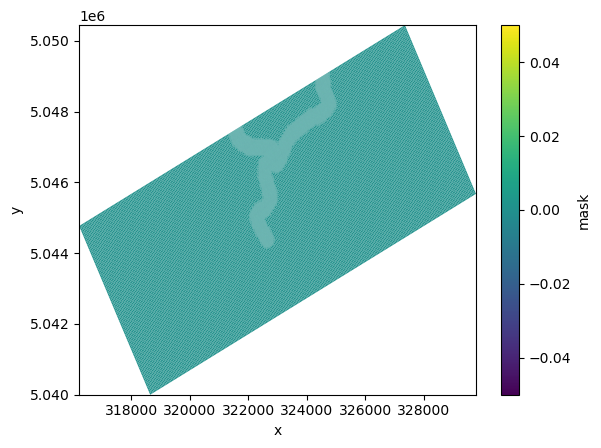

In [16]:
# %matplotlib qt
%matplotlib inline

qt.set_mask(model="sfincs",zmin=-5, zmax=5)
qt.data["mask"].ugrid.plot()

Build new mask for:snapwave...


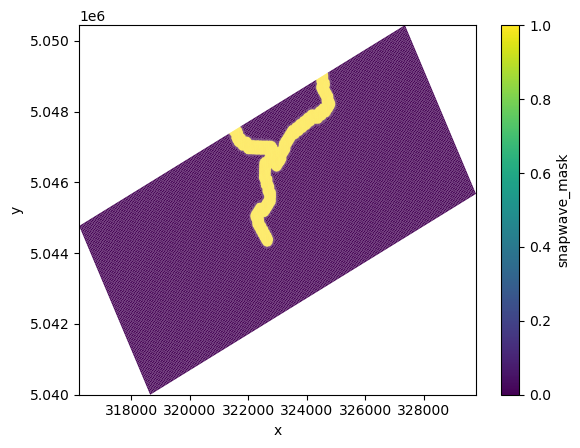

In [17]:
qt.set_mask(model="snapwave",zmin=-5, zmax=5, include_polygon=gdf_riv_buf) #> doesnt work yet because of expect z values in set_mask, I removed this criteria for now (/question whether we want this behaviour, that include_polygon doesn't overrule)
qt.data["snapwave_mask"].ugrid.plot()

In [18]:
qt.write("sfincs_snapwave.nc")

Try situation where we want to directly copy the SFINCS mask to SnapWave:

Build new mask for:sfincs...


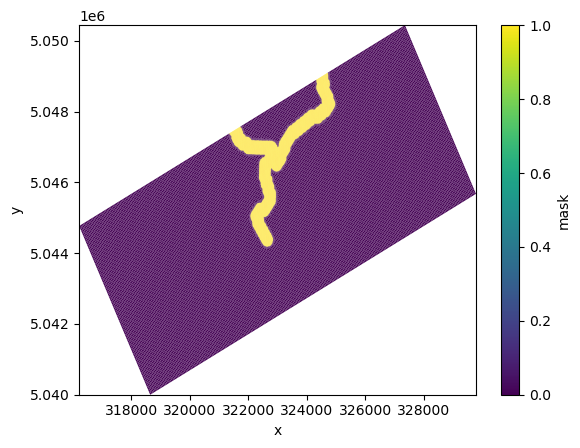

In [19]:
qt.set_mask(model="sfincs",zmin=-5, zmax=5, include_polygon=gdf_riv_buf) #> doesnt work yet because of expect z values in set_mask, I removed this criteria for now (/question whether we want this behaviour, that include_polygon doesn't overrule)
qt.data["mask"].ugrid.plot()

Using SFINCS mask for Snapwave mask ...


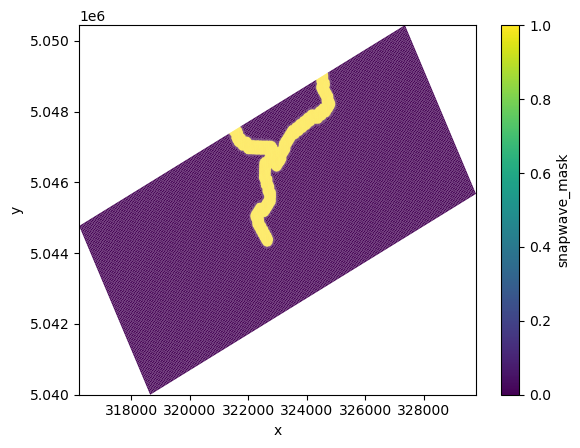

In [21]:
qt.set_mask(model="snapwave", copy_sfincs_mask2snapwave=True)
qt.data["snapwave_mask"].ugrid.plot()

In [ ]:
qt.write("sfincs_snapwave_v2.nc")